In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [64]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.energy_consumption import Energy2011
from src.Constants import Constants

# 1. Energy consumption in buildings

In [35]:
data = pd.read_csv('../data/vinkovci_grijanje_2011.csv')

* Convert to MWh

In [36]:
data['potrošnja_toplinske_energije(MWh)'] = data['potrošnja_toplinske_energije(kWh)'] / 1000

* Group by category and energy source

In [45]:
data.groupby(['kategorija', 'energent'])['potrošnja_toplinske_energije(MWh)'].sum()

kategorija                          energent           
komercijalne I uslužne djelatnosti  električna energija     2340.44800
                                    lož ulje                6441.28200
                                    ogrjevno drvo          23188.61520
                                    prirodni plin          62307.56056
kulturne ustanove                   lož ulje                  63.25826
                                    prirodni plin            657.67756
objekti i uredi gradskih tvrtki     prirodni plin            473.13697
stambeni sektor                     električna energija    15646.12000
                                    lož ulje                5760.00351
                                    ogrjevno drvo          41250.80853
                                    prirodni plin          85563.07134
uprava                              električna energija       37.80000
                                    prirodni plin            593.80058
školstvo             

* Total consumption by energy source

In [46]:
data.groupby(['energent'])['potrošnja_toplinske_energije(MWh)'].sum()

energent
električna energija     18024.36800
lož ulje                12279.84819
ogrjevno drvo           64439.42373
prirodni plin          152814.69127
Name: potrošnja_toplinske_energije(MWh), dtype: float64

* Total consumption

In [48]:
data.groupby(['energent'])['potrošnja_toplinske_energije(MWh)'].sum().sum()

247558.33119

# Electrical energy consumption

In [49]:
ele = pd.read_csv('../data/vinkovci_struja_2011.csv')

In [51]:
ele['potrošnja_električne_energije(MWh)'] = ele['potrošnja_električne_energije(kWh)'] / 1000

* Consumption by category

In [53]:
ele.groupby('kategorija')['potrošnja_električne_energije(MWh)'].sum()

kategorija
komercijalne I uslužne djelatnosti    27390.000
kulturne ustanove                       125.700
objekti I uredi gradskih tvrtki          98.861
stambeni sektor                       54014.000
uprava                                  121.466
školstvo                                455.890
Name: potrošnja_električne_energije(MWh), dtype: float64

* Total consumption

In [54]:
ele.groupby('kategorija')['potrošnja_električne_energije(MWh)'].sum().sum()

82205.917

## Transportation consumption

In [66]:
constant = Constants()

In [56]:
c_transport = pd.read_csv('../data/gradska_vozila_2011.csv')

In [72]:
c_transport.iloc[1][

vlasništvo               grad
vrsta_goriva            dizel
potrošnja_goriva(l)    5767.0
Name: 1, dtype: object

In [73]:
c_transport_kwh_diesel = c_transport.iloc[1]['potrošnja_goriva(l)'] * constant.diesel_litre_to_kwh

In [74]:
c_transport_kwh_petrol = c_transport.iloc[0]['potrošnja_goriva(l)'] * constant.petrol_litre_to_kwh

* Total MWh for city owned cars

In [78]:
(c_transport_kwh_diesel + c_transport_kwh_petrol) / 1000

132.0070008

* Litre consumption for private transport

In [121]:
p_transport = pd.read_csv('../data/privatna_vozila_2011.csv')
petrol_l = p_transport.loc[p_transport['vrsta_prijevoza'] == 'osobna vozila']['procijenjena_potrošena_masa_benzina(t)'] * constant.petrol_ton_to_litre
diesel_l = p_transport.loc[p_transport['vrsta_prijevoza'] == 'osobna vozila']['procijenjena_potrošena_masa_dizela(t)'] * constant.diesel_ton_to_litre
lpg = p_transport.loc[p_transport['vrsta_prijevoza'] == 'osobna vozila']['procijenjena_potrošena_masa_unp(t)'] * constant.lpg_ton_to_litre

In [123]:
petrol_l, diesel_l, lpg

(3    3048357.72
 Name: procijenjena_potrošena_masa_benzina(t), dtype: float64,
 3    1231795.5
 Name: procijenjena_potrošena_masa_dizela(t), dtype: float64,
 3    88408.1
 Name: procijenjena_potrošena_masa_unp(t), dtype: float64)

* to MWh

In [124]:
((petrol_l * constant.petrol_litre_to_kwh) + (diesel_l * constant.diesel_litre_to_kwh) + (lpg * constant.lpg_litre_to_kwh)) / 1000

3    43421.125717
dtype: float64

* Litre consumption for industrial vehicles

In [107]:
p_transport

,vrsta_prijevoza,broj,procijenjena_potrošena_masa_benzina(t),procijenjena_potrošena_masa_dizela(t),procijenjena_potrošena_masa_unp(t),procijenjena_potrošnja_goriva(kWh),broj_dizelskih,broj_putničkih_mjesta,potrošnja_dizelskog_goriva(l),prijeđeni_kilometri,broj_preveznih_putnika
0,autobusni,6,NaN,13.9,NaN,179119.3,6.0,337.0,16343.0,56774.3,24507.0
1,željeznički,10585,NaN,NaN,NaN,NaN,NaN,NaN,360870.0,400000.0,3000000.0
2,taxi,1,NaN,NaN,NaN,NaN,1.0,NaN,1850.0,NaN,NaN
3,osobna vozila,10005,2194.8,1047.0,44.9,40191449.6,NaN,NaN,NaN,NaN,NaN
4,teretna I radna vozila,2102,108.1,1557.0,NaN,19810355.8,NaN,NaN,NaN,NaN,NaN
5,mopedi i motocikli,910,53.0,NaN,NaN,657072.6,NaN,NaN,NaN,NaN,NaN
6,kombinirana vozila,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
petrol_l = p_transport.loc[p_transport['vrsta_prijevoza'] == 'teretna I radna vozila']['procijenjena_potrošena_masa_benzina(t)'] * constant.petrol_ton_to_litre
diesel_l = p_transport.loc[p_transport['vrsta_prijevoza'] == 'teretna I radna vozila']['procijenjena_potrošena_masa_dizela(t)'] * constant.diesel_ton_to_litre

In [109]:
petrol_l, diesel_l

(4    150140.09
 Name: procijenjena_potrošena_masa_benzina(t), dtype: float64,
 4    1831810.5
 Name: procijenjena_potrošena_masa_dizela(t), dtype: float64)

In [110]:
((petrol_l * constant.petrol_litre_to_kwh) + (diesel_l * constant.diesel_litre_to_kwh)) / 1000

4    21519.489345
dtype: float64

* Bikes

In [111]:
petrol_l = p_transport.loc[p_transport['vrsta_prijevoza'] == 'mopedi i motocikli']['procijenjena_potrošena_masa_benzina(t)'] * constant.petrol_ton_to_litre
diesel_l = p_transport.loc[p_transport['vrsta_prijevoza'] == 'mopedi i motocikli']['procijenjena_potrošena_masa_dizela(t)'] * constant.diesel_ton_to_litre

In [112]:
petrol_l, diesel_l

(5    73611.7
 Name: procijenjena_potrošena_masa_benzina(t), dtype: float64,
 5   NaN
 Name: procijenjena_potrošena_masa_dizela(t), dtype: float64)

In [115]:
(petrol_l * constant.petrol_litre_to_kwh) / 1000

5    707.408437
Name: procijenjena_potrošena_masa_benzina(t), dtype: float64

* Bus

In [118]:
p_transport.loc[p_transport['vrsta_prijevoza'] == 'autobusni']['potrošnja_dizelskog_goriva(l)'][0] * constant.diesel_litre_to_kwh

179119.28000000003

* taxi

In [120]:
p_transport.loc[p_transport['vrsta_prijevoza'] == 'taxi']['potrošnja_dizelskog_goriva(l)'] * constant.diesel_litre_to_kwh

2    20276.0
Name: potrošnja_dizelskog_goriva(l), dtype: float64

## Energy charts

In [125]:
charts = Energy2011()

/home/dionizije/Documents/vk_secap/src/energy_consumption.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chart = plt.pie(


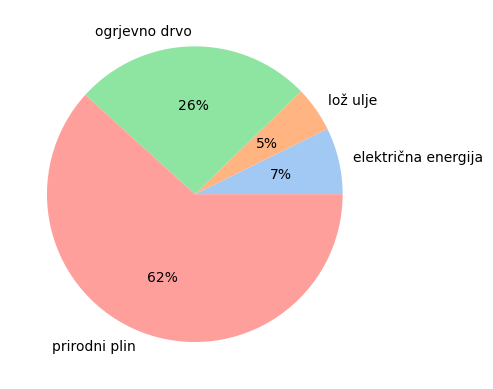

In [49]:
toplina_izvor = charts.heat_by_source()

/home/dionizije/Documents/vk_secap/src/energy_consumption.py:56: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chart = plt.pie(


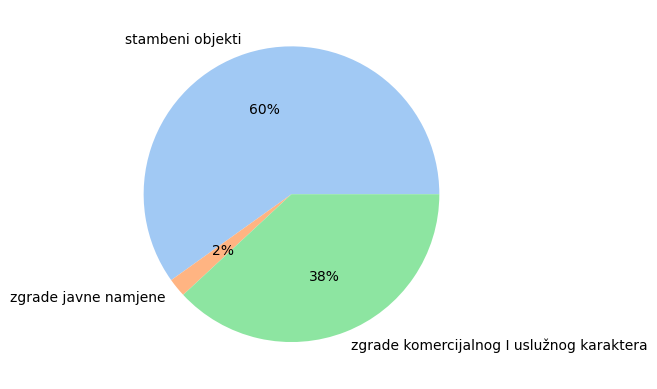

In [50]:
toplina_sektor = charts.energy_by_sector('heat')

/home/dionizije/Documents/vk_secap/src/energy_consumption.py:56: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chart = plt.pie(


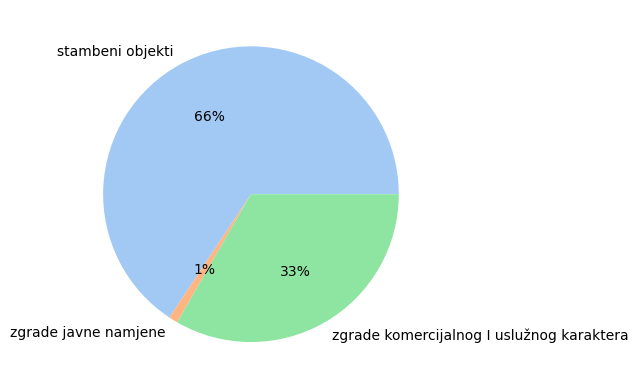

In [51]:
struja_sektor = charts.energy_by_sector('electricity')

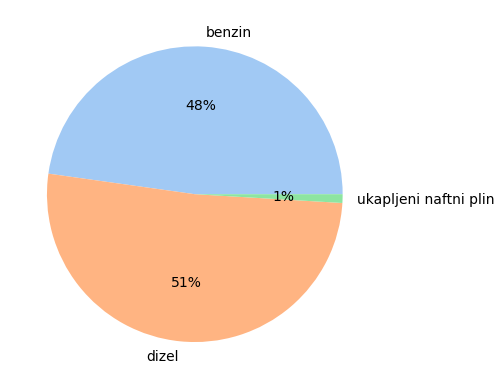

In [150]:
gas_by_type = charts.gas_by_type()

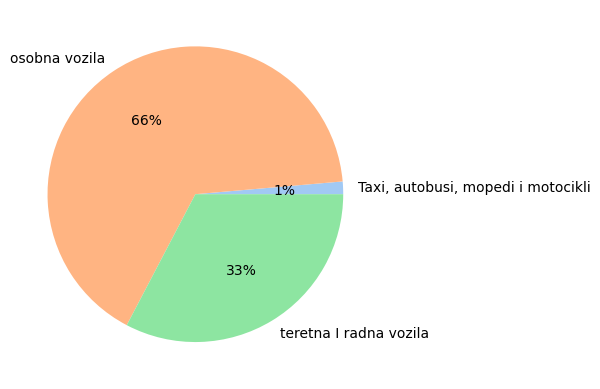

In [149]:
gas_by_category = charts.gas_by_category()